<a href="https://colab.research.google.com/github/sachsac/teaching_data/blob/main/TA_Hours_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
df = pd.read_excel('/content/drive/MyDrive/Work/Independent Projects/TA work/TA helping.xlsx')
df.drop(columns='Student', inplace = True) #dropping for anonymity
df.head()

,Cohort,Time,Date,Day of week,Time in Military,Off Hours Request? Y/N
0,Sherlin,18:12:00,2021-12-22,Wed,1812,No
1,Sherlin,19:27:00,2021-12-12,Sun,1927,Yes
2,Josh,20:16:00,2022-01-05,Wed,2016,No
3,Josh,23:05:00,2021-12-09,Thu,2305,No
4,Josh,21:25:00,2021-12-08,Wed,2125,No


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cohort                  48 non-null     object        
 1   Time                    48 non-null     object        
 2   Date                    48 non-null     datetime64[ns]
 3   Day of week             48 non-null     object        
 4   Time in Military        48 non-null     int64         
 5   Off Hours Request? Y/N  48 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.4+ KB


In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

# Can we predict if a student will contact after hours vs during hours?
(A Classification Problem)
Although the Regression Problem was unable to be tackled using this data, can it more reliably help with a classification question?

In [288]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [289]:
#although it is the same data set, we need to redo our train test split and preprocessing steps
X = df.drop(columns = 'Off Hours Request? Y/N')
y = df['Off Hours Request? Y/N']

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [291]:
#code to check the split of our variables
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))

Counts of each class in Training: {'No': 22, 'Yes': 14}
Counts of each class in Test: {'No': 7, 'Yes': 5}


In [292]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [293]:
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [294]:
col_trans = make_column_transformer(num_tuple, cat_tuple)
col_trans.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd8239510>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd8239090>)])

In [295]:
X_train = col_trans.transform(X_train)
X_test = col_trans.transform(X_test)

In [296]:
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True))
print()
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True))  

Baseline Training Accuracy:
No     0.611111
Yes    0.388889
Name: Off Hours Request? Y/N, dtype: float64

Baseline Testing Accuracy:
No     0.583333
Yes    0.416667
Name: Off Hours Request? Y/N, dtype: float64


In [297]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic Regression Performance')
print(metrics.classification_report(y_test, y_pred))
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)
print('KNN Performance')
print(metrics.classification_report(y_test, y_pred2))
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)
print('XGB Performance')
print(metrics.classification_report(y_test, y_pred3))


Logistic Regression Performance
              precision    recall  f1-score   support

          No       0.78      1.00      0.88         7
         Yes       1.00      0.60      0.75         5

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12

KNN Performance
              precision    recall  f1-score   support

          No       0.71      0.71      0.71         7
         Yes       0.60      0.60      0.60         5

    accuracy                           0.67        12
   macro avg       0.66      0.66      0.66        12
weighted avg       0.67      0.67      0.67        12

XGB Performance
              precision    recall  f1-score   support

          No       1.00      1.00      1.00         7
         Yes       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted a

XGB actually performs very well for this problem without hypertuning.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


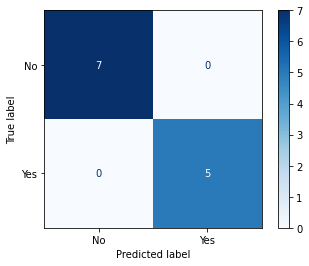

In [298]:
plot_confusion_matrix(xgb, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.suptitle('');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is